# Import Fish Data

In [5]:
import pandas as pd

In [6]:
Data = pd.read_csv("MergedData.csv")

In [7]:
Data.head()

,Date,Kasillof_Count,Species,Water Temperature,Tide_Value,Type,Kenai_River_Count
0,2024-08-09,6480.0,Sockeye,56.512,2.572,Low,11937.0
1,2024-08-09,6480.0,Sockeye,56.512,19.868,High,11937.0
2,2024-08-09,6480.0,Sockeye,56.512,18.789,High,11937.0
3,2024-08-09,6480.0,Sockeye,56.512,2.060,Low,11937.0
4,2024-08-08,6474.0,Sockeye,56.646,0.372,Low,6858.0


# Prepping Data for Nueral Network

## Add lagged Tide Feature

In [8]:
Data = Data.iloc[::-1]
for i in range(1,6,1):
        Data[f"Tide{i}"] = Data["Tide_Value"].shift(i)


uniqueExtract = Data[["Date","Kasillof_Count", "Kenai_River_Count", "Water Temperature", "Tide_Value", "Tide1", "Tide2", "Tide3", "Tide4", "Tide5"]]

uniqueExtract = uniqueExtract.drop_duplicates(subset = ['Date'], keep = 'last')

uniqueExtract.head()


,Date,Kasillof_Count,Kenai_River_Count,Water Temperature,Tide_Value,Tide1,Tide2,Tide3,Tide4,Tide5
4969,2004-06-15,4566.0,NaN,49.208,6.060,18.132,-0.591,19.791,NaN,NaN
4965,2004-06-16,2187.0,NaN,49.096,-1.157,19.854,18.600,6.141,6.060,18.132
4961,2004-06-17,1747.0,NaN,49.058,6.076,18.949,-1.512,19.878,-1.157,19.854
4958,2004-06-18,3048.0,NaN,49.425,19.159,19.851,-1.684,6.076,18.949,-1.512
4954,2004-06-19,3251.0,NaN,49.892,-1.668,19.217,5.931,19.734,19.159,19.851


## Add lagged fish count and temperature feature

In [9]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')

uniqueExtract["Date"] = pd.to_datetime(uniqueExtract["Date"])
uniqueExtract = uniqueExtract.sort_values(by = "Date")

Start_Date = "2004-01-01"
End_Date = "2025-01-01"

mlpData = pd.DataFrame()


for year in range(2004,2026):
    subset = uniqueExtract[(uniqueExtract["Date"] > f"{year}-01-01") & (uniqueExtract["Date"] < f"{year+1}-01-01") ]

    
    for i in range(1,6,1):
        subset[f"lag{i}_Fish_Kas"] = subset["Kasillof_Count"].shift(i)
        subset[f"lag{i}_Fish_Ken"] = subset["Kenai_River_Count"].shift(i)
        subset[f"lag{i}_Temp"] = subset["Water Temperature"].shift(i)
 
    subset["Target"] = subset["Kasillof_Count"].shift(-1)
    mlpData = pd.concat([mlpData,subset.iloc[5:len(subset)-1,]], axis = 0)  

mlpData = mlpData.fillna(0)
    

## Add in Time Invariant Fixed Effects 

In [10]:
import datetime
dOY = []
dM = []
dYR = []

for time in mlpData["Date"]:
    dOY.append(time.timetuple().tm_yday)
    dM.append(time.timetuple().tm_mon)
    dYR.append(time.timetuple().tm_year)
    
mlpData["Day of Year"] = dOY
mlpData["Month"] = dM
mlpData["Year"] = dYR
mlpData.head()

mlpData.to_csv("mlpData.csv")

# Create a Basic MLP Architecture

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

X = mlpData.drop( ["Date", "Target"],axis = 1)
print(X.shape)

Y = mlpData["Target"]


fishModel = Sequential([
    Dense(16, input_shape = (27,), activation = "relu"),
    Dense(10, activation = "linear"),
    Dense(1, activation = "linear")
])

fishModel.compile(optimizer = Adam(), loss = "mean_squared_error", metrics = ["mean_squared_error"])

print(fishModel.summary())

Index(['Kasillof_Count', 'Kenai_River_Count', 'Water Temperature',
       'Tide_Value', 'Tide1', 'Tide2', 'Tide3', 'Tide4', 'Tide5',
       'lag1_Fish_Kas', 'lag1_Fish_Ken', 'lag1_Temp', 'lag2_Fish_Kas',
       'lag2_Fish_Ken', 'lag2_Temp', 'lag3_Fish_Kas', 'lag3_Fish_Ken',
       'lag3_Temp', 'lag4_Fish_Kas', 'lag4_Fish_Ken', 'lag4_Temp',
       'lag5_Fish_Kas', 'lag5_Fish_Ken', 'lag5_Temp', 'Day of Year', 'Month',
       'Year'],
      dtype='object')


'\nY = mlpData["Target"]\n\n\nfishModel = Sequential([\n    Dense(16, input_shape = (27,), activation = "relu"),\n    Dense(10, activation = "linear"),\n    Dense(1, activation = "linear")\n])\n\nfishModel.compile(optimizer = Adam(), loss = "mean_squared_error", metrics = ["mean_squared_error"])\n\nprint(fishModel.summary())\n'

# Train the Model

In [85]:
fishModel.fit(X,Y, epochs = 10, batch_size = 1, shuffle = False, validation_split = 0.1)
fishModel.save("FishModel")

Epoch 1/10
1044/1044 [==============================] - 2s 2ms/step - loss: 108415528.0000 - mean_squared_error: 108415528.0000 - val_loss: 264613744.0000 - val_mean_squared_error: 264613744.0000
Epoch 2/10
1044/1044 [==============================] - 2s 2ms/step - loss: 44663104.0000 - mean_squared_error: 44663104.0000 - val_loss: 258158256.0000 - val_mean_squared_error: 258158256.0000
Epoch 3/10
1044/1044 [==============================] - 2s 2ms/step - loss: 38164364.0000 - mean_squared_error: 38164364.0000 - val_loss: 218380400.0000 - val_mean_squared_error: 218380400.0000
Epoch 4/10
1044/1044 [==============================] - 2s 2ms/step - loss: 34590656.0000 - mean_squared_error: 34590656.0000 - val_loss: 193924304.0000 - val_mean_squared_error: 193924304.0000
Epoch 5/10
1044/1044 [==============================] - 2s 2ms/step - loss: 32709172.0000 - mean_squared_error: 32709172.0000 - val_loss: 182184928.0000 - val_mean_squared_error: 182184928.0000
Epoch 6/10
1044/1044 [======

# How well Does the Model Forecast Fish Inflows in 2024?

2/2 [==============================] - 0s 2ms/step


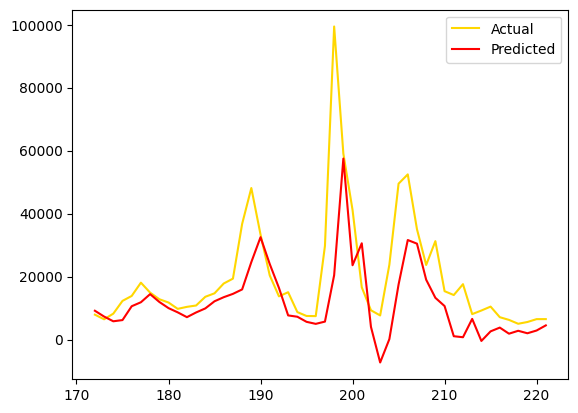

In [86]:
import matplotlib.pyplot as pyplot


fishModel = tf.keras.models.load_model("FishModel")
X_2024 = mlpData[ mlpData["Year"] == 2024].drop( ["Date", "Target"],axis = 1)
Y_2024 = mlpData[ mlpData["Year"] == 2024]["Target"]
X_Axis = mlpData[ mlpData["Year"] == 2024]["Day of Year"]

Fit = fishModel.predict(X_2024)
pyplot.plot(X_Axis, Y_2024, label = "Actual", color = "gold")
pyplot.plot(X_Axis, Fit, label = "Predicted", color = "red")
pyplot.legend()